In [1]:
import torch
import torch_geometric
import h5py
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy as sp
from torch_geometric.utils import to_undirected

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
import sys
sys.path.insert(0, '../')
from graph import Graph, Trajectory
from datasets import TDriveTrajectoryDataset, GeoDriveTrajectoryDataset

In [8]:
#data = TDriveTrajectoryDataset('/ceph/hdd/students/zhzo/tdrive.h5', n_samples=10, min_trajectory_length=5, max_trajectory_length=8, edge_format='srctar')
data = GeoDriveTrajectoryDataset('../data/GeoLife/merged.h5', n_samples=10, min_trajectory_length=5, max_trajectory_length=8, edge_format='srctar')

In [9]:
data[0][2]

tensor([5518,  617])

NetworkXError: Node tensor(0) has no position.

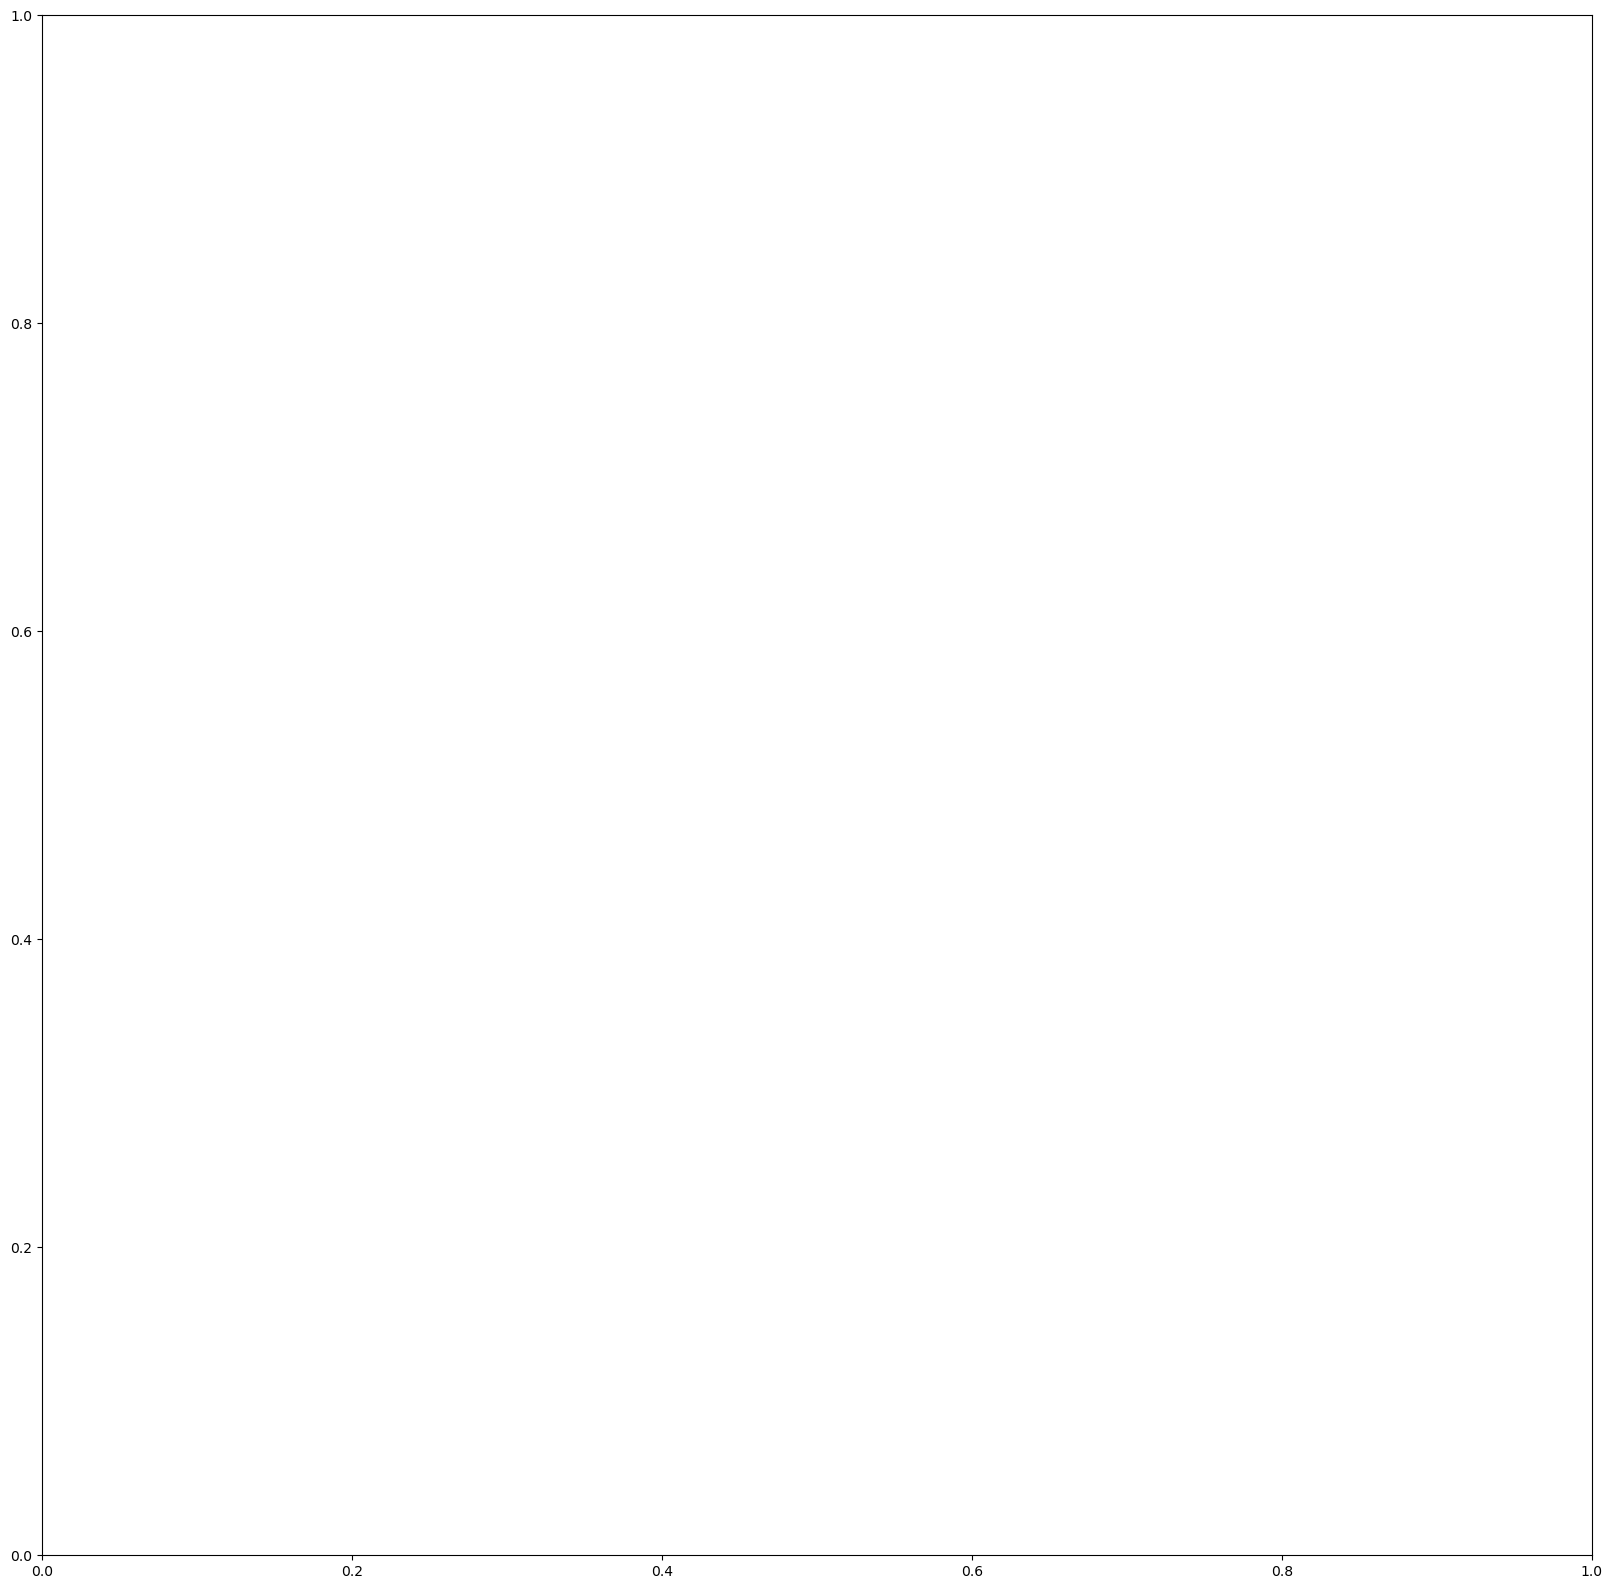

In [10]:
fig, ax = plt.subplots(figsize=(20, 20))
data.trajectories[0].plot(data.graph, ax)

In [11]:
# only use batch_size=1 for now
# each batch contains full trajectory, masking has to happen later
dataloader1 = torch.utils.data.DataLoader(data, batch_size=1, shuffle= False)

In [12]:
for sample in dataloader1:
    print(sample)

tensor([[[   9,  617],
         [ 617, 5518],
         [5518,  617],
         [ 617, 2380],
         [2380, 5518],
         [5518,  617]]])
tensor([[[ 617, 5518],
         [5518, 8360],
         [8360, 5518],
         [5518,  617],
         [ 617,    9],
         [   9, 1884]]])
tensor([[[2444, 6326],
         [6326, 2824],
         [2824, 6387],
         [6387, 2441],
         [2441,  374],
         [ 374, 8332],
         [8332, 5568],
         [5568, 8548]]])
tensor([[[6006, 6704],
         [6704, 5071],
         [5071, 6020],
         [6020, 1985],
         [1985, 3404]]])
tensor([[[   9,  617],
         [ 617,  597],
         [ 597,   11],
         [  11, 2045],
         [2045, 8272],
         [8272, 8273],
         [8273,   12],
         [  12, 2683]]])
tensor([[[2683,   12],
         [  12, 2045],
         [2045,   11],
         [  11,  597],
         [ 597,  617],
         [ 617, 5518]]])
tensor([[[2683,   63],
         [  63, 1176],
         [1176, 4787],
         [4787, 2380],

In [13]:
dataloader2 = torch.utils.data.DataLoader(data, batch_size=1, shuffle= True)

In [14]:
for sample in dataloader2:
    print(sample)

tensor([[[ 617, 5518],
         [5518, 2380],
         [2380, 5518],
         [5518, 8360],
         [8360, 8362],
         [8362, 8361]]])
tensor([[[   9,  617],
         [ 617,  597],
         [ 597,   11],
         [  11, 2045],
         [2045, 8272],
         [8272, 8273],
         [8273,   12],
         [  12, 2683]]])
tensor([[[2683,   63],
         [  63, 1176],
         [1176, 4787],
         [4787, 2380],
         [2380, 5518],
         [5518, 2380],
         [2380,  617],
         [ 617, 5518]]])
tensor([[[ 617, 2380],
         [2380, 4787],
         [4787, 1176],
         [1176,   63],
         [  63, 2683]]])
tensor([[[2444, 6326],
         [6326, 2824],
         [2824, 6387],
         [6387, 2441],
         [2441,  374],
         [ 374, 8332],
         [8332, 5568],
         [5568, 8548]]])
tensor([[[2683,   12],
         [  12, 2045],
         [2045,   11],
         [  11,  597],
         [ 597,  617],
         [ 617, 5518]]])
tensor([[[6006, 6704],
         [6704, 5071],

In [15]:
from torch_geometric.nn import GCNConv
from torch_geometric.nn.dense import DenseGCNConv
import torch.nn.functional as F
from tqdm import tqdm

In [53]:
class SimpleGNN(torch.nn.Module):
	def __init__(self, node_features):
		super().__init__()
		self.conv1 = GCNConv(node_features+1, 32)
		self.conv2 = GCNConv(32, 16)
		self.linear = torch.nn.Linear(16, 1)

	def forward(self, x, edge_index):

		x = self.conv1(x, edge_index)
		x = F.relu(x)
		next_node = self.conv2(x, edge_index)
		next_node = F.relu(next_node)
		next_node = self.linear(next_node)

		return next_node

In [54]:
feature_dim = 0

model = SimpleGNN(data.graph.node_coordinates.shape[1] + feature_dim).to(device)

In [55]:
#min_history = 3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

losses = []
accuracies = []

In [61]:
# local_loss == True: Apply loss function only to neighbors of last node
# local_loss == False: Apply loss function to all nodes of graph
local_loss = True

model.train()
epochs = tqdm(range(10), desc='')
for epoch in epochs:
    epoch_accuracy = []
    epoch_loss = []
    for batch in dataloader1:
        batch = batch.squeeze(0).to(device)
        nfeatures = torch.tensor(data.graph.node_coordinates).to(device)            
        nfeatures = torch.concat([nfeatures, torch.randn(nfeatures.shape[0], feature_dim).to(device)], dim=1)
        
        on_path = torch.zeros(nfeatures.shape[0], 1, device=device)        
        on_path[batch.flatten()[:-1]] = 1
        
        nfeatures = torch.concat([nfeatures, on_path], dim=1).to(dtype=torch.float32)
        next_node = model(nfeatures, data_edge_index)
        
        last_node = batch[-1][0].item()
        
        last_node_neighbors = list(data.graph.get_neighbors(last_node))
        neighbor_scores = next_node[last_node_neighbors]
        target_node = torch.tensor(last_node_neighbors.index(batch[-1][1].cpu().item()), device=device)

        if local_loss:
            loss = loss_fn(neighbor_scores.squeeze(1), target_node)
        else:
            loss = loss_fn(next_node.squeeze(1), batch[-1][1])
        

        loss.backward()        
        epoch_loss.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()

    accuracies.append(np.array(epoch_accuracy).mean())
    losses.append(np.array(epoch_loss).mean())
    epochs.set_description(f"{losses[-1]:.4f} {accuracies[-1]:.3f}")
        

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_3677318/520644615.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nfeatures = torch.tensor(data.graph.node_coordinates).to(device)
/tmp/ipykernel_3677318/520644615.py:38: RuntimeWarning: Mean of empty slice.
  accuracies.append(np.array(epoch_accuracy).mean())
1.5020 nan: 100%|██████████| 10/10 [00:00<00:00, 21.72it/s]


Text(0.5, 1.0, 'accuracy')

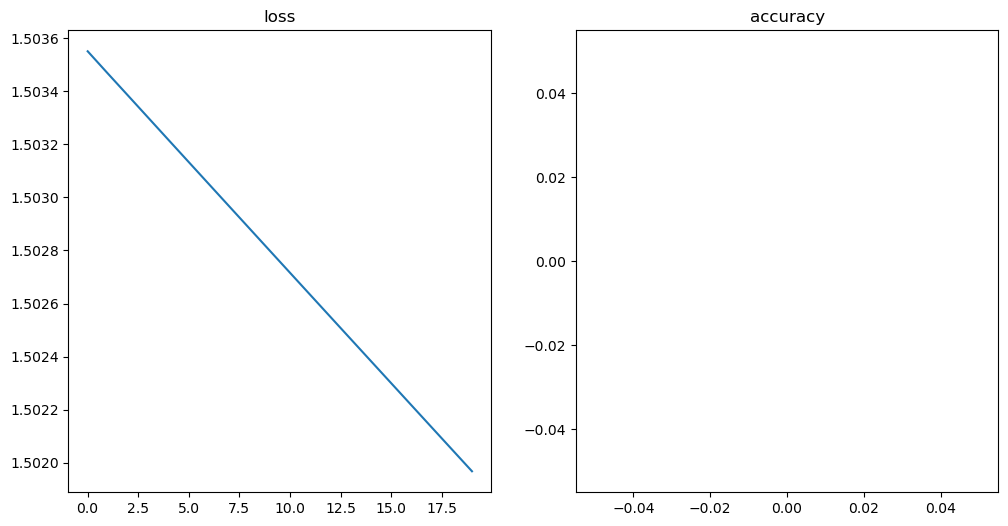

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(np.arange(len(losses)), np.array(losses))
axs[0].set_title("loss")
axs[1].plot(np.arange(len(accuracies)), np.array(accuracies))
axs[1].set_title("accuracy")